In [77]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import numpy as np

In [78]:
#Load data
results_production = pd.read_csv('results_production.csv', delimiter=',') 
results_unit_commitment = pd.read_csv('results_unit_comitment.csv', delimiter=',')

In [79]:
results_production.head()

,hour,generation 1,generation 2,generation 3,wind generation 1,wind generation 2,load 1,load 2,load 3,epsilon 1,...,transmission_up_binding_L3,transmission_down_binding_L3,transmission_up_binding_L4,transmission_down_binding_L4,transmission_up_binding_L5,transmission_down_binding_L5,transmission_up_binding_L6,transmission_down_binding_L6,transmission_up_binding_L7,transmission_down_binding_L7
0,0,100.0,0.0,10.000000,0.0,5.044859,7.190304,57.522429,50.332126,0.0,...,False,False,False,False,False,False,False,False,False,False
1,1,100.0,0.0,10.000000,0.0,7.889218,7.368076,58.944609,51.576533,0.0,...,False,False,False,False,False,False,False,False,False,False
2,2,100.0,0.0,10.000000,0.0,12.197143,7.637321,61.098571,53.461250,0.0,...,False,False,False,False,False,False,False,False,False,False
3,3,100.0,0.0,10.000000,0.0,5.828420,7.239276,57.914210,50.674934,0.0,...,False,False,False,False,False,False,False,False,False,False
4,4,100.0,0.0,11.403747,0.0,18.951910,8.147229,65.177829,57.030600,0.0,...,True,False,False,False,False,False,False,False,False,False


In [80]:
features = results_production[['wind generation 1', 'wind generation 2', 'load 1', 'load 2', 'load 3']]
# Use the unit commitment results as labels
labels = results_unit_commitment[['G1', 'G2', 'G3']]

# Separate features (X) and labels (y)
X = features
y = labels


# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
print(f"Training Set: {X_train.shape}, Validation Set: {X_val.shape}, Test Set: {X_test.shape}")


Training Set: (1680, 5), Validation Set: (360, 5), Test Set: (360, 5)


In [81]:
# Check if units are always ON or OFF
print(y_train.mean())  # If mean = 1 or 0, the unit is always ON or OFF

# Units to classify
units_to_classify = [col for col in labels.columns if 0 < y_train[col].mean() < 1]
print(f"Units to classify: {units_to_classify}")

G1    1.000000
G2    0.272024
G3    0.964881
dtype: float64
Units to classify: ['G2', 'G3']


In [87]:
# Linear Classifier
# Define logistic regression models for each generator
logistic_models = {}
# Loop through each generator but the base generator
for unit in units_to_classify:  # e.g. 'G2', 'G3'
    # Extract training and validation data for this unit
    y_val_unit = y_val[unit]
    # Initialize and train the logistic regression model
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train[unit])
    logistic_models[unit] = model


In [89]:
## Non-Linear Classifier
# Define SVM models for each generator with multiple kernels
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
svm_models = {kernel: {} for kernel in kernels}  # Store models for each kernel

# Loop through each generator and train SVM with different kernels
for kernel in kernels:
    for unit in units_to_classify:  # e.g., 'G1', 'G2', 'G3'
        # Initialize and train the SVM model
        model = SVC(kernel=kernel, class_weight='balanced', random_state=42)
        #svm = SVC(kernel=kernel, class_weight='balanced', random_state=42) --> dealing with class imbalance
        model.fit(X_train, y_train[unit])
        svm_models[kernel][unit] = model


In [90]:
#Evaluation and Reporting
def evaluate_model(model, X, y, units, model_type, kernel=None):
    """Evaluate a model and print metrics."""
    results = {}
    for unit in units:
        y_pred = model[unit].predict(X) if kernel is None else model[kernel][unit].predict(X)
        accuracy = accuracy_score(y[unit], y_pred)
        report = classification_report(y[unit], y_pred, output_dict=True)
        print(f"\n{model_type} ({'Kernel: ' + kernel if kernel else ''}) - {unit}")
        print(f"Accuracy: {accuracy:.3f}")
        print(classification_report(y[unit], y_pred))
        results[unit] = {"accuracy": accuracy, "report": report}
    return results

# Logistic Regression Evaluation
logistic_results = evaluate_model(logistic_models, X_test, y_test, units_to_classify, model_type="Logistic Regression")

# SVM Evaluation for all kernels
svm_results = {}
for kernel in kernels:
    print(f"\nEvaluating SVM ({kernel} kernel)...")
    svm_results[kernel] = evaluate_model(svm_models, X_test, y_test, units_to_classify, model_type="SVM", kernel=kernel)



Logistic Regression () - G2
Accuracy: 0.889
              precision    recall  f1-score   support

         0.0       0.92      0.93      0.92       256
         1.0       0.82      0.79      0.80       104

    accuracy                           0.89       360
   macro avg       0.87      0.86      0.86       360
weighted avg       0.89      0.89      0.89       360


Logistic Regression () - G3
Accuracy: 1.000
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        14
         1.0       1.00      1.00      1.00       346

    accuracy                           1.00       360
   macro avg       1.00      1.00      1.00       360
weighted avg       1.00      1.00      1.00       360


Evaluating SVM (linear kernel)...

SVM (Kernel: linear) - G2
Accuracy: 0.872
              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91       256
         1.0       0.74      0.86      0.79       104

    accuracy  

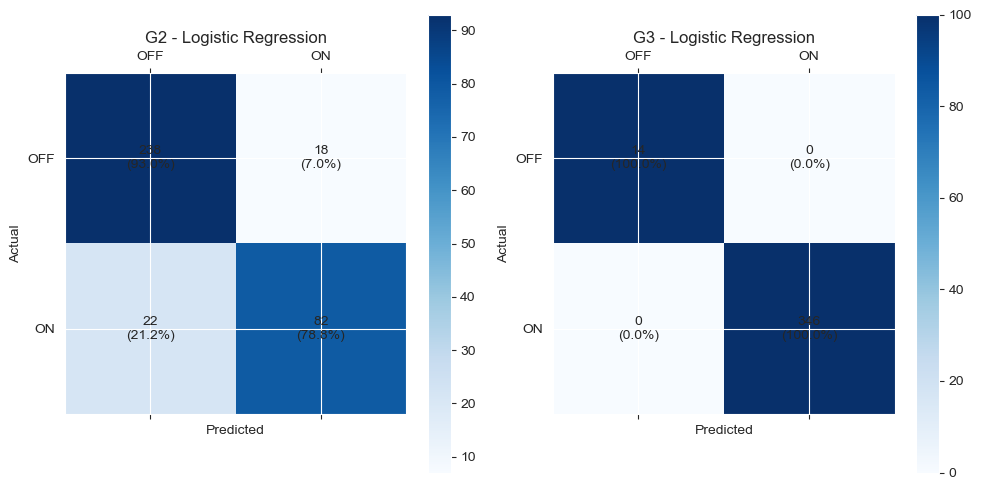

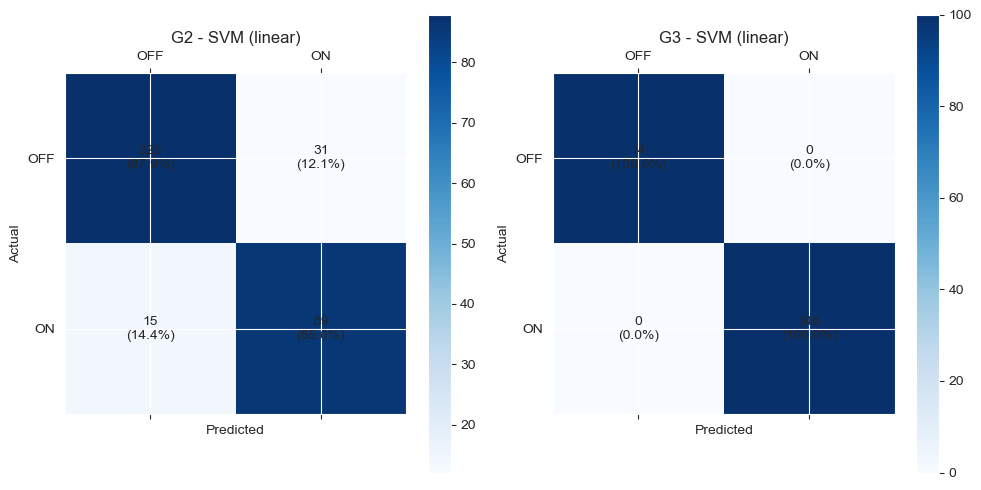

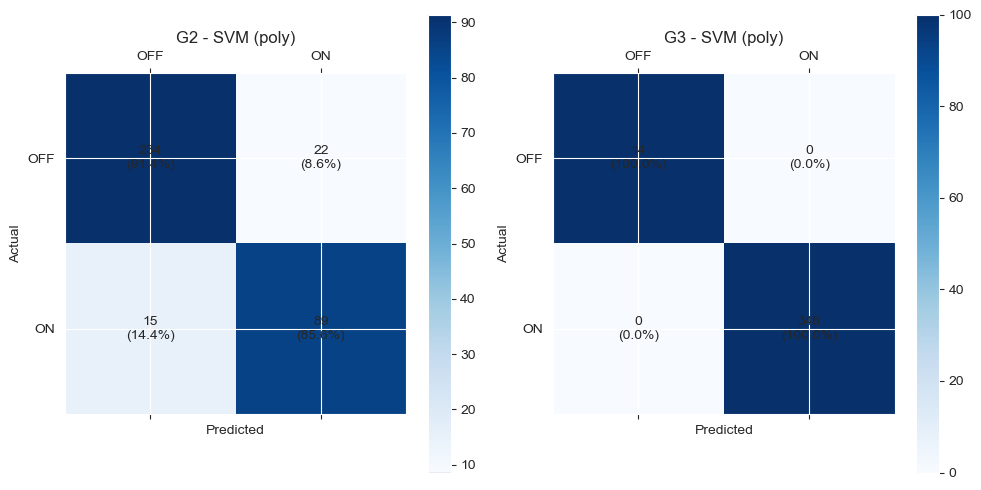

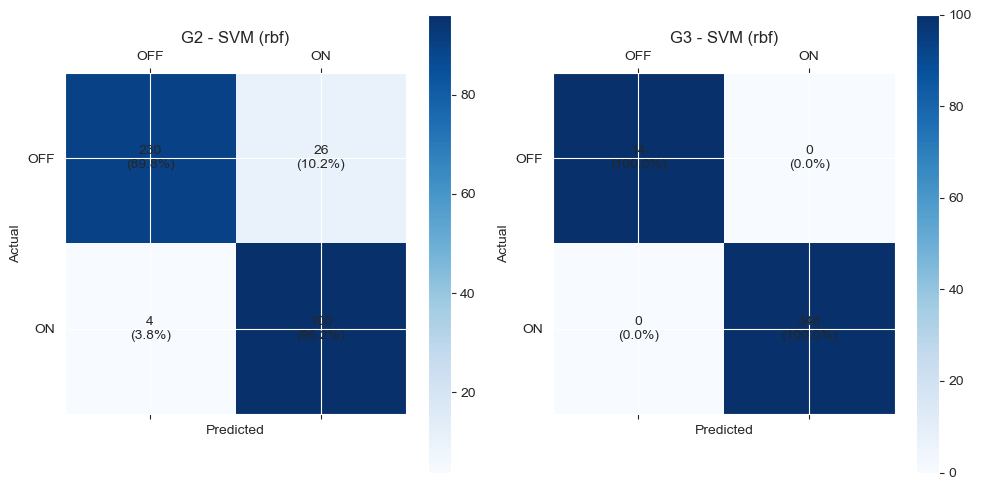

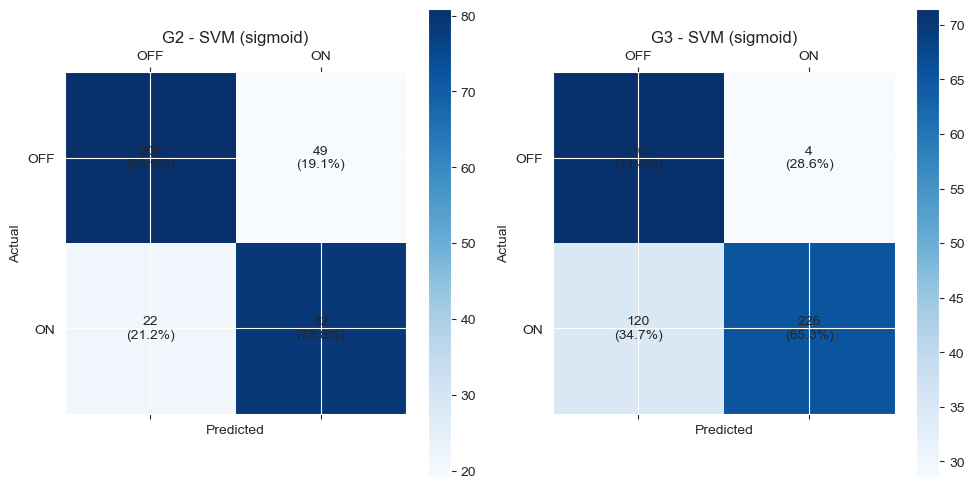

In [86]:
#Visualization: Confusion Matrices
def plot_confusion_matrices(models, units, model_type, X, y, kernels=None):
    """Plot confusion matrices for given models."""
    if model_type == "Logistic Regression":
        fig, axes = plt.subplots(1, len(units), figsize=(5 * len(units), 5))
        for idx, unit in enumerate(units):
            y_pred = models[unit].predict(X)
            cm = confusion_matrix(y[unit], y_pred)
            ax = axes[idx] if len(units) > 1 else axes
            plot_confusion_matrix_on_ax(cm, ['OFF', 'ON'], ax, title=f"{unit} - {model_type}")
        plt.tight_layout()
        plt.show()
    elif model_type == "SVM":
        for kernel in kernels:
            fig, axes = plt.subplots(1, len(units), figsize=(5 * len(units), 5))
            for idx, unit in enumerate(units):
                y_pred = models[kernel][unit].predict(X)
                cm = confusion_matrix(y[unit], y_pred)
                ax = axes[idx] if len(units) > 1 else axes
                plot_confusion_matrix_on_ax(cm, ['OFF', 'ON'], ax, title=f"{unit} - SVM ({kernel})")
            plt.tight_layout()
            plt.show()

def plot_confusion_matrix_on_ax(cm, classes, ax, title):
    """Helper function to plot a confusion matrix on an axis."""
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    cax = ax.matshow(cm_percentage, cmap='Blues')
    ax.figure.colorbar(cax, ax=ax)
    for (i, j), value in np.ndenumerate(cm):
        ax.text(j, i, f"{value}\n({cm_percentage[i, j]:.1f}%)", ha="center", va="center")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

# Plot Confusion Matrices
plot_confusion_matrices(logistic_models, units_to_classify, "Logistic Regression", X_test, y_test)
plot_confusion_matrices(svm_models, units_to_classify, "SVM", X_test, y_test, kernels=kernels)